<font size=6>**计算机视觉**</font>

# 图像增广
在“深度卷积神经网络（AlexNet）”小节里我们提到过，大规模数据集是成功应用深度神经网络的前提。图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以**降低模型对某些属性的依赖**，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。可以说，在当年AlexNet的成功中，图像增广技术功不可没。本节我们将讨论这个在计算机视觉里被广泛使用的技术。

首先，导入实验所需的包或模块。

In [1]:
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd,init,gluon,nd,image
from mxnet.gluon import data as gdata,loss as gloss,utils as gutils
import sys
import time
%matplotlib inline

## 常用的图像增广的方法
我们来读取一张形状为 400×500 （高和宽分别为400像素和500像素）的图像作为实验的样例。

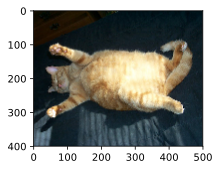

In [2]:
d2l.set_figsize()
img=image.imread('./img/cat1.jpg')
d2l.plt.imshow(img.asnumpy())

下面定义绘图函数show_images。

In [3]:
def show_images(imgs,num_rows,num_cols,scale=2):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols+j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

大部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个辅助函数apply。这个函数对输入图像img多次运行图像增广方法aug并展示所有的结果。

In [4]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1):
    Y=[aug(img) for _ in range(num_rows*num_cols)]
    show_images(Y,num_rows,num_cols,scale)

## 图像翻转和裁剪
左右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面我们通过transforms模块创建RandomFlipLeftRight实例来实现一半概率的图像左右翻转。

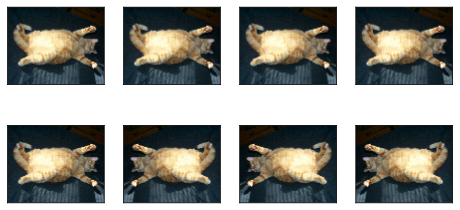

In [5]:
apply(img,gdata.vision.transforms.RandomFlipLeftRight(),scale=2)

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们创建RandomFlipTopBottom实例来实现一半概率的图像上下翻转。

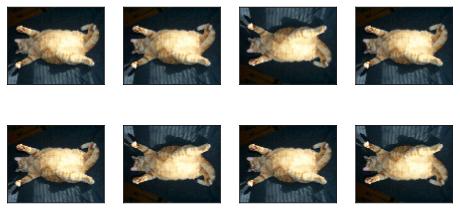

In [6]:
apply(img,gdata.vision.transforms.RandomFlipTopBottom(),scale=2)

在我们使用的样例图像里，猫在图像正中间，但一般情况下可能不是这样。在“池化层”一节里我们解释了池化层能降低卷积层对目标位置的敏感度。除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。

在下面的代码里，我们每次随机裁剪出一块面积为原面积 10%∼100% 的区域，且该区域的宽和高之比随机取自 0.5∼2 ，然后再将该区域的宽和高分别缩放到200像素。若无特殊说明，本节中 a 和 b 之间的随机数指的是从区间 [a,b] 中随机均匀采样所得到的连续值。

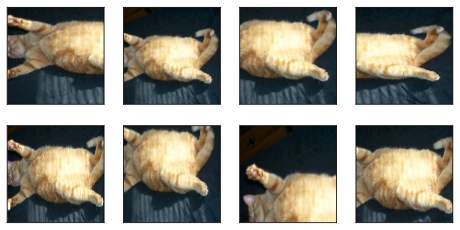

In [7]:
shape_aug=gdata.vision.transforms.RandomResizedCrop((200,200),scale=(0.1,1),ratio=(0.5,2))
apply(img,aug=shape_aug,scale=2)

## 颜色变化

另一类增广方法是变化颜色。我们可以从4个方面改变图像的颜色：亮度、对比度、饱和度和色调。在下面的例子里，我们将图像的亮度随机变化为原图亮度的 50% （ 1−0.5 ） ∼150% （ 1+0.5 ）。

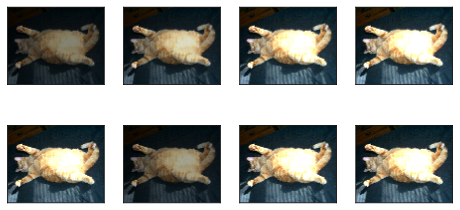

In [8]:
apply(img,gdata.vision.transforms.RandomBrightness(0.5),scale=2)

我们也可以随机变化图像的色调。

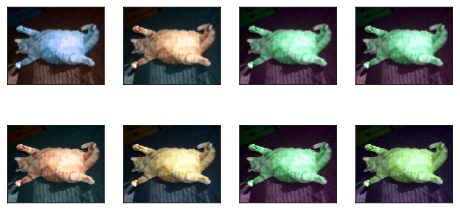

In [9]:
apply(img,gdata.vision.transforms.RandomHue(0.5),scale=2)

我们也可以创建RandomColorJitter实例并同时设置如何随机变化图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。

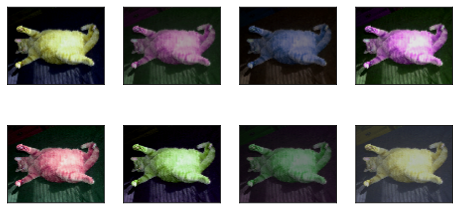

In [10]:
color_aug=gdata.vision.transforms.RandomColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5)
apply(img,color_aug,scale=2)

## 叠加多个图像增广方法
实际应用中我们会将多个图像增广方法叠加使用。我们可以通过Compose实例将上面定义的多个图像增广方法叠加起来，再应用到每张图像之上。

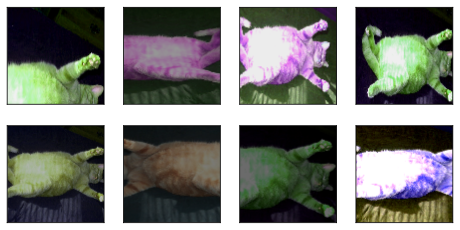

In [11]:
augs=gdata.vision.transforms.Compose([gdata.vision.transforms.RandomFlipLeftRight(),color_aug,shape_aug])
apply(img,augs,scale=2)

## 使用图片增广训练模型
下面我们来看一个将图像增广应用在实际训练中的例子。这里我们使用CIFAR-10数据集，而不是之前我们一直使用的Fashion-MNIST数据集。这是因为Fashion-MNIST数据集中物体的位置和尺寸都已经经过归一化处理，而CIFAR-10数据集中物体的颜色和大小区别更加显著。下面展示了CIFAR-10数据集中前32张训练图像。

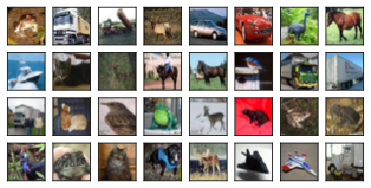

In [12]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0],4,8,scale=0.8);

为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。在这里我们只使用最简单的随机左右翻转。此外，我们使用ToTensor实例将小批量图像转成MXNet需要的格式，即形状为(批量大小, 通道数, 高, 宽)、值域在0到1之间且类型为32位浮点数。

In [13]:
flip_aug=gdata.vision.transforms.Compose([gdata.vision.transforms.RandomFlipLeftRight(),gdata.vision.transforms.ToTensor()])
no_aug=gdata.vision.transforms.Compose([gdata.vision.transforms.ToTensor()])

接下来我们定义一个辅助函数来方便读取图像并应用图像增广。Gluon的数据集提供的transform_first函数将图像增广应用在每个训练样本（图像和标签）的第一个元素，即图像之上。有关DataLoader的详细介绍，可参考更早的“图像分类数据集（Fashion-MNIST）”一节。

In [21]:
num_works=0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train,augs,batch_size):
    return gdata.DataLoader(gdata.vision.CIFAR10(train=is_train).transform_first(augs),
                            batch_size=batch_size,shuffle=is_train,num_workers=num_works)

## 使用多GPU训练网络模型
首先，我们定义try_all_gpus函数，从而能够获取所有可用的GPU。

In [15]:
def try_all_gpu():
    ctxes=[]
    try:
        for i in range(16):
            ctx=mx.gpu(i)
            _=nd.array([0],ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes=[mx.cpu()]
    return ctxes

下面定义的辅助函数\_get_batch将小批量数据样本batch划分并复制到ctx变量所指定的各个显存上。

In [16]:
def _get_batch(batch,ctx):
    features,labels=batch
    if labels.dtype!=features.dtype:
        labels=labels.astype(features.dtype)
    return (gutils.split_and_load(features,ctx),gutils.split_and_load(labels,ctx),features.shape[0])

然后，我们定义evaluate_accuracy函数评价模型的分类准确率。与“softmax回归的从零开始实现”和“卷积神经网络（LeNet）”两节中描述的evaluate_accuracy函数不同，这里定义的函数更加通用：它通过辅助函数\_get_batch使用ctx变量所包含的所有GPU来评价模型。

In [17]:

In [17]:
def evaluate_accuracy(data_iter,net,ctx=[mx.cpu()]):
    if isinstance(ctx,mx.Context):#不是列表转化为列表
        ctx=[ctx]
    acc_sum,n=nd.array([0]),0
    for batch in data_iter:
        features,labels,_=_get_batch(batch,ctx)
        for X,y in zip(features,labels):
            y=y.astype('float32')
            acc_sum+=(net(X).argmax(axis=1)==y).sum().copyto(mx.cpu())
            n+=y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar()/n

接下来，我们定义train函数使用多GPU训练并评价模型。

In [27]:
def train(net,train_iter,test_iter,loss,trainer,ctx,num_epochs):
    print('training on',ctx)
    if isinstance(ctx,mx.Context):
        ctx=[ctx]
    for epoch in range(num_epochs):
        train_ls_sum,train_acc_sum,n,m,start=0.0,0.0,0,0,time.time()
        for i,batch in enumerate(train_iter):
            Xs,ys,batch_size=_get_batch(batch,ctx)
            ls=[]
            with autograd.record():
                y_hats=[net(X) for X in Xs]
                ls=[loss(y_hat,y) for y_hat,y in zip(y_hats,ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_ls_sum+=sum([l.sum().asscalar() for l in ls])
            n+=sum([l.size for l in ls])
            train_acc_sum+=sum([(y_hat.argmax(axis=1)==y).sum().asscalar() for y_hat,y in zip(y_hats,ys)])
            m+=sum([y.size for y in ys])
        test_acc=evaluate_accuracy(test_iter,net,ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_ls_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))

现在就可以定义train_with_data_aug函数使用图像增广来训练模型了。该函数获取了所有可用的GPU，并将Adam算法作为训练使用的优化算法，然后将图像增广应用于训练数据集之上，最后调用刚才定义的train函数训练并评价模型。

In [19]:
def train_with_data_aug(train_augs,test_augs,lr=0.001):
    batch_size,ctx,net=256,try_all_gpu(),d2l.resnet18(10)
    net.initialize(ctx=ctx,init=init.Xavier())
    trainer=gluon.Trainer(net.collect_params(),'adam',{'learning_rate':lr})
    loss=gloss.SoftmaxCrossEntropyLoss()
    train_iter=load_cifar10(True,train_augs,batch_size)
    test_iter=load_cifar10(False,test_augs,batch_size)
    train(net,train_iter,test_iter,loss,trainer,ctx,num_epochs=2)

In [28]:
train_with_data_aug(flip_aug,no_aug)

training on [gpu(0)]
epoch 1, loss 1.3726, train acc 0.515, test acc 0.570, time 121.6 sec
epoch 2, loss 0.8124, train acc 0.711, test acc 0.698, time 119.0 sec


## 思考
对image进行tranform是非常耗时的，可以使用第三方库方法来进行图片增广，如opencv。

# 微调
在前面的一些章节中，我们介绍了如何在只有6万张图像的Fashion-MNIST训练数据集上训练模型。我们还描述了学术界当下使用最广泛的大规模图像数据集ImageNet，它有超过1,000万的图像和1,000类的物体。然而，我们平常接触到数据集的规模通常在这两者之间。

假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一种可能的方法是先找出100种常见的椅子，为每种椅子拍摄1,000张不同角度的图像，然后在收集到的图像数据集上训练一个分类模型。这个椅子数据集虽然可能比Fashion-MNIST数据集要庞大，但样本数仍然不及ImageNet数据集中样本数的十分之一。这可能会导致适用于ImageNet数据集的复杂模型在这个椅子数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集ImageNet数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用迁移学习（transfer learning），将从源数据集学到的知识迁移到目标数据集上。例如，虽然ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等。这些类似的特征对于识别椅子也可能同样有效。

本节我们介绍迁移学习中的一种常用技术：微调（fine tuning）。如图9.1所示，微调由以下4步构成。

* 在源数据集（如ImageNet数据集）上预训练一个神经网络模型，即源模型。
* 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
* 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
* 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。
![](http://zh.d2l.ai/_images/finetune.svg)
当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。

## 热狗识别
接下来我们来实践一个具体的例子：热狗识别。我们将基于一个小数据集对在ImageNet数据集上训练好的ResNet模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。

首先，导入实验所需的包或模块。Gluon的model_zoo包提供了常用的预训练模型。如果希望获取更多的计算机视觉的预训练模型，可以使用GluonCV工具包 [1]。

In [1]:
import d2lzh as d2l
from mxnet import gluon,init,nd
from mxnet.gluon import data as gdata,loss as gloss,model_zoo
from mxnet.gluon import utils as gutils
import os
import zipfile
%matplotlib inline

## 获取数据集
我们使用的热狗数据集是从网上抓取的，它含有1400张包含热狗的正类图像，和同样多包含其他食品的负类图像。各类的1000张图像被用于训练，其余则用于测试。

我们首先将压缩后的数据集下载到路径../data之下，然后在该路径将下载好的数据集解压，得到两个文件夹hotdog/train和hotdog/test。这两个文件夹下面均有hotdog和not-hotdog两个类别文件夹，每个类别文件夹里面是图像文件。

In [2]:
data_dir='./data'
base_url='http://apache-mxnet.s3-accelerate.amazonaws.com/'
fname=gutils.download(base_url+'gluon/dataset/hotdog.zip',path=data_dir,sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')
with zipfile.ZipFile(fname,'r') as z:
    z.extractall(data_dir)

我们创建两个ImageFolderDataset实例来分别读取训练数据集和测试数据集中的所有图像文件。

In [3]:
train_imgs=gdata.vision.ImageFolderDataset(os.path.join(data_dir,'hotdog/train'))
test_imgs=gdata.vision.ImageFolderDataset(os.path.join(data_dir,'hotdog/test'))

下面画出前8张正类图像和最后8张负类图像。可以看到，它们的大小和高宽比各不相同。

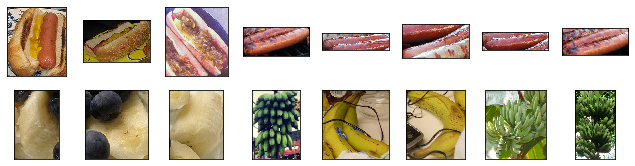

In [4]:
hotdogs=[train_imgs[i][0] for i in range(8)]
not_hotdogs=[train_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs,2,8,scale=1.4);

在训练时，我们先从图像中裁剪出随机大小和随机高宽比的一块随机区域，然后将该区域缩放为高和宽均为224像素的输入。测试时，我们将图像的高和宽均缩放为256像素，然后从中裁剪出高和宽均为224像素的中心区域作为输入。此外，我们对RGB（红、绿、蓝）三个颜色通道的数值做标准化：每个数值减去该通道所有数值的平均值，再除以该通道所有数值的标准差作为输出。

In [5]:
normalize=gdata.vision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])#三个通道的均值和方差

train_augs=gdata.vision.transforms.Compose([gdata.vision.transforms.RandomResizedCrop((224,224)),
                                           gdata.vision.transforms.RandomFlipLeftRight(),
                                           gdata.vision.transforms.ToTensor(),
                                           normalize])
test_augs=gdata.vision.transforms.Compose([gdata.vision.transforms.Resize((256,256)),
                                          gdata.vision.transforms.CenterCrop(224),
                                          gdata.vision.transforms.ToTensor(),
                                          normalize])

 ## 定义和初始化模型
 我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。这里指定pretrained=True来自动下载并加载预训练的模型参数。在第一次使用时需要联网下载模型参数。

In [6]:
pretrained_net=model_zoo.vision.resnet18_v2(pretrained=True)

预训练的源模型实例含有两个成员变量，即features和output。前者包含模型除输出层以外的所有层，后者为模型的输出层。这样划分主要是为了方便微调除输出层以外所有层的模型参数。下面打印源模型的成员变量output。作为一个全连接层，它将ResNet最终的全局平均池化层输出变换成ImageNet数据集上1000类的输出。

In [7]:
pretrained_net.output

Dense(512 -> 1000, linear)

我们新建一个神经网络作为目标模型。它的定义与预训练的源模型一样，但最后的输出个数等于目标数据集的类别数。在下面的代码中，目标模型实例finetune_net的成员变量features中的模型参数被初始化为源模型相应层的模型参数。由于features中的模型参数是在ImageNet数据集上预训练得到的，已经足够好，因此一般只需使用较小的学习率来微调这些参数。而成员变量output中的模型参数采用了随机初始化，一般需要更大的学习率从头训练。假设Trainer实例中的学习率为 η ，我们设成员变量output中的模型参数在迭代中使用的学习率为 10η 。

In [8]:
finetune_net=model_zoo.vision.resnet18_v2(classes=2)#定义一个和源模型一样的目标模型，只是输出层不一样
finetune_net.features=pretrained_net.features #将源模型处理输出层的参数copy到目标模型
finetune_net.output.initialize(init=init.Xavier()) #只对输出层参数进行初始化

# output中的模型参数将在迭代中使用10倍大的学习率
finetune_net.output.collect_params().setattr('lr_mult',10)

## 微调模型
我们先定义一个使用微调的训练函数train_fine_tuning以便多次调用。

In [11]:
def train_fime_tuning(net,learning_rate,batch_size=64,num_epochs=5):
    train_iter=gdata.DataLoader(train_imgs.transform_first(train_augs),batch_size,shuffle=True)
    test_iter=gdata.DataLoader(test_imgs.transform_first(test_augs),batch_size)
    ctx=d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    loss=gloss.SoftmaxCrossEntropyLoss()
    trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':learning_rate,'wd':0.001})
    d2l.train(train_iter,test_iter,net,loss,trainer,ctx,num_epochs)

In [12]:
train_fime_tuning(finetune_net,0.01,num_epochs=1)

training on [gpu(0)]


MXNetError: [11:23:39] c:\jenkins\workspace\mxnet\mxnet\src\operator\tensor\../mxnet_op.h:680: Check failed: err == cudaSuccess (2 vs. 0) Name: mxnet_generic_kernel ErrStr:out of memory

可以看到，微调的模型因为参数初始值更好，往往在相同迭代周期下取得更高的精度。

## 练习
* 将finetune_net.features中的参数固定为源模型的参数而不在训练中迭代，结果会怎样？你可能会用到以下代码。
finetune_net.features.collect_params().setattr('grad_req','null')

* 事实上ImageNet数据集里也有“hotdog”（热狗）这个类。它在输出层对应的权重参数可以用以下代码获取。我们可以怎样使用这个权重参数？

In [11]:
weight=pretrained_net.output.weight
hotdog_w=nd.split(weight.data(),1000,axis=0)[713]
hotdog_w.shape

(1, 512)

In [14]:
nd.split(nd.array([[1,2,3],[4,5,6]]),2,axis=0)

[
 [[1. 2. 3.]]
 <NDArray 1x3 @cpu(0)>, 
 [[4. 5. 6.]]
 <NDArray 1x3 @cpu(0)>]

# 目标检测和边界框
在前面的一些章节中，我们介绍了诸多用于图像分类的模型。在图像分类任务里，我们假设图像里只有一个主体目标，并关注如何识别该目标的类别。然而，很多时候图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。在计算机视觉里，我们将这类任务称为目标检测（object detection）或物体检测。

目标检测在多个领域中被广泛使用。例如，在无人驾驶里，我们需要通过识别拍摄到的视频图像里的车辆、行人、道路和障碍的位置来规划行进线路。机器人也常通过该任务来检测感兴趣的目标。安防领域则需要检测异常目标，如歹徒或者炸弹。

在接下来的几节里，我们将介绍目标检测里的多个深度学习模型。在此之前，让我们来了解目标位置这个概念。先导入实验所需的包或模块。

In [2]:
import d2lzh as d2l
from mxnet import image
%matplotlib inline

下面加载本节将使用的示例图像。可以看到图像左边是一只狗，右边是一只猫。它们是这张图像里的两个主要目标。

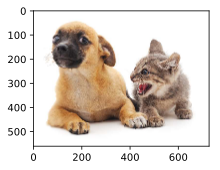

In [3]:
d2l.set_figsize()
img=image.imread('./img/catdog.jpg').asnumpy()
d2l.plt.imshow(img)

## 边界框
在目标检测里，我们通常使用边界框（bounding box）来描述目标位置。边界框是一个矩形框，可以由矩形左上角的 x 和 y 轴坐标与右下角的 x 和 y 轴坐标确定。我们根据上面的图的坐标信息来定义图中狗和猫的边界框。图中的坐标原点在图像的左上角，原点往右和往下分别为 x 轴和 y 轴的正方向。

In [4]:
dog_bbox,cat_bbox=[60,45,378,516],[400,112,655,493]

我们可以在图中将边界框画出来，以检查其是否准确。画之前，我们定义一个辅助函数bbox_to_rect。它将边界框表示成matplotlib的边界框格式。

In [5]:
def bbox_to_rect(bbox,color):
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return d2l.plt.Rectangle(xy=(bbox[0],bbox[1]),width=bbox[2]-bbox[0],height=bbox[3]-bbox[1],fill=False,edgecolor=color,linewidth=2)

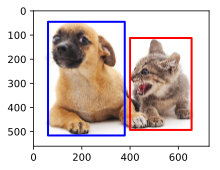

In [6]:
fig=d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox,'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox,'red'));

In [7]:
fig.axes

# 锚框
目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边缘从而更准确地预测目标的真实边界框（ground-truth bounding box）。不同的模型使用的区域采样方法可能不同。这里我们介绍其中的一种方法：它以每个像素为中心生成多个大小和宽高比（aspect ratio）不同的边界框。这些边界框被称为锚框（anchor box）。我们将在后面基于锚框实践目标检测。

首先，导入本节需要的包或模块。这里我们新引入了contrib包，并修改了NumPy的打印精度。由于NDArray的打印实际调用NumPy的打印函数，本节打印出的NDArray中的浮点数更简洁一些。

In [8]:
import d2lzh as d2l
from mxnet import contrib,gluon,image,nd
import numpy as np
%matplotlib inline

In [9]:
np.set_printoptions(2) #设置打印类型

## 生成多个锚框
假设输入图像高为 h ，宽为 w 。我们分别以图像的每个像素为中心生成不同形状的锚框。设大小为 s∈(0,1] 且宽高比为 r>0 ，那么锚框的宽和高将分别为 $ws\sqrt{r} 和 \frac{hs}{\sqrt{r}}$ 。当中心位置给定时，已知宽和高的锚框是确定的。

下面我们分别设定好一组大小 $s_1,…,s_n$ 和一组宽高比 $r_1,…,r_m$ 。如果以每个像素为中心时使用所有的大小与宽高比的组合，输入图像将一共得到 $whnm$ 个锚框。虽然这些锚框可能覆盖了所有的真实边界框，但计算复杂度容易过高。因此，我们通常只对包含 $s_1 或 r_1$ 的大小与宽高比的组合感兴趣，即

$(s_1,r_1),(s_1,r_2),…,(s_1,r_m),(s_2,r_1),(s_3,r_1),…,(s_n,r_1)$.
 
也就是说，以相同像素为中心的锚框的数量为 n+m−1 。对于整个输入图像，我们将一共生成 $wh(n+m−1)$ 个锚框。

以上生成锚框的方法已实现在**MultiBoxPrior**函数中。指定输入、一组大小和一组宽高比，该函数将返回输入的所有锚框。

In [10]:
img=image.imread('./img/catdog.jpg').asnumpy()
h,w=img.shape[0:2]

print(h,w)
X=nd.random.uniform(shape=(1,3,h,w))#构造输入数据
Y=contrib.nd.MultiBoxPrior(X,sizes=[0.75,0.5,0.25],ratios=[1,2,0.5])
Y.shape

561 728


(1, 2042040, 4)

In [11]:
Y[0]


[[-0.29 -0.37  0.29  0.38]
 [-0.19 -0.25  0.19  0.25]
 [-0.1  -0.12  0.1   0.13]
 ...
 [ 0.9   0.87  1.1   1.12]
 [ 0.59  0.73  1.41  1.26]
 [ 0.79  0.47  1.2   1.53]]
<NDArray 2042040x4 @cpu(0)>

我们看到，返回锚框变量y的形状为（批量大小，锚框个数，4）。将锚框变量y的形状变为（图像高，图像宽，以相同像素为中心的锚框个数，4）后，我们就可以通过指定像素位置来获取所有以该像素为中心的锚框了。下面的例子里我们访问以（250，250）为中心的第一个锚框。它有4个元素，分别是锚框左上角的 x 和 y 轴坐标和右下角的 x 和 y 轴坐标，其中 x 和 y 轴的坐标值分别已除以图像的宽和高，因此值域均为0和1之间。

In [15]:
boxes=Y.reshape(h,w,-1,4)
boxes[250,250,:,:]


[[ 0.06  0.07  0.63  0.82]
 [ 0.15  0.2   0.54  0.7 ]
 [ 0.25  0.32  0.44  0.57]
 [-0.06  0.18  0.75  0.71]
 [ 0.14 -0.08  0.55  0.98]]
<NDArray 5x4 @cpu(0)>

为了描绘图像中以某个像素为中心的所有锚框，我们先定义show_bboxes函数以便在图像上画出多个边界框。

In [44]:
def show_bboxes(axes,bboxes,labels=None,colors=None):
    def _make_list(obj,default_values=None):
        if obj is None:
            obj=default_values
        elif not isinstance(obj,(list,tuple)):
            obj=[obj]
        return obj
    
    labels=_make_list(labels)
    colors=_make_list(colors,['b','g','r','m','c'])
    for i,bbox in enumerate(bboxes):
        color=colors[i%len(colors)]
        rect=d2l.bbox_to_rect(bbox.asnumpy(),color)
        axes.add_patch(rect)
        if labels and len(labels)>i:
            text_color='k' if color=='w' else 'w' #文字的颜色在k和w翻转。若边框为w则文字为k，否则为w w:白色
            axes.text(rect.xy[0],rect.xy[1],labels[i],  
                     va='center',ha='center',fontsize=9,
                     color=text_color,bbox=dict(facecolor=color,lw=0))#这里bbox为文字的边框

刚刚我们看到，变量boxes中 x 和 y 轴的坐标值分别已除以图像的宽和高。在绘图时，我们需要恢复锚框的原始坐标值，并因此定义了变量bbox_scale。现在，我们可以画出图像中以(250, 250)为中心的所有锚框了。可以看到，大小为0.75且宽高比为1的锚框较好地覆盖了图像中的狗。

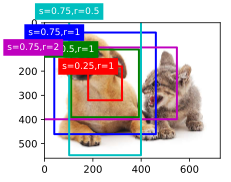

In [14]:
d2l.set_figsize()
bbox_scale=nd.array((w,h,w,h))#恢复原始坐标值
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,boxes[250,250,:,:]*bbox_scale,
           ['s=0.75,r=1','s=0.5,r=1','s=0.25,r=1','s=0.75,r=2','s=0.75,r=0.5'])

## 交并化
我们刚刚提到某个锚框较好地覆盖了图像中的狗。如果该目标的真实边界框已知，这里的“较好”该如何量化呢？一种直观的方法是衡量锚框和真实边界框之间的相似度。我们知道，Jaccard系数（Jaccard index）可以衡量两个集合的相似度。给定集合 A 和 B ，它们的Jaccard系数即二者交集大小除以二者并集大小：

$J(A,B)=\frac{|A∩B|}{|A∪B|}.$
 
实际上，我们可以把边界框内的像素区域看成是像素的集合。如此一来，我们可以用两个边界框的像素集合的Jaccard系数衡量这两个边界框的相似度。当衡量两个边界框的相似度时，我们通常将Jaccard系数称为交并比（Intersection over Union，IoU），即两个边界框相交面积与相并面积之比，如图9.2所示。交并比的取值范围在0和1之间：0表示两个边界框无重合像素，1表示两个边界框相等。

![](http://zh.d2l.ai/_images/iou.svg)
在本节的剩余部分，我们将使用交并比来衡量锚框与真实边界框以及锚框与锚框之间的相似度。

## 标注训练集的锚框
在训练集中，我们将每个锚框视为一个训练样本。为了训练目标检测模型，我们需要为每个锚框标注两类标签：一是锚框所含目标的类别，简称类别；二是真实边界框相对锚框的偏移量，简称偏移量（offset）。在目标检测时，我们首先生成多个锚框，然后为每个锚框预测类别以及偏移量，接着根据预测的偏移量调整锚框位置从而得到预测边界框，最后筛选需要输出的预测边界框。

我们知道，在目标检测的训练集中，每个图像已标注了真实边界框的位置以及所含目标的类别。在生成锚框之后，我们主要依据与锚框相似的真实边界框的位置和类别信息为锚框标注。那么，该如何为锚框分配与其相似的真实边界框呢？

假设图像中锚框分别为 $A_1,A_2,…,A_{n_a}$ ，真实边界框分别为 $B_1,B_2,…,B_{n_b}$ ，且 $n_a≥n_b$ 。定义矩阵 $X∈R^{n_a×n_b}$ ，其中第 i 行第 j 列的元素 $x_{ij}$ 为锚框 $A_i$ 与真实边界框 $B_j$ 的交并比。 首先，我们找出矩阵 X 中最大元素，并将该元素的行索引与列索引分别记为 $i_1,j_1$ 。我们为锚框 $A_{i_1}$ 分配真实边界框 $B_{j_1}$ 。显然，锚框 $A_{i_1}$ 和真实边界框 $B_{j_1}$ 在所有的“锚框—真实边界框”的配对中相似度最高。接下来，将矩阵 X 中第 $i_1$ 行和第 $j_1$ 列上的所有元素丢弃。找出矩阵 X 中剩余的最大元素，并将该元素的行索引与列索引分别记为 $i_2,j_2$ 。我们为锚框 $A_{i_2}$ 分配真实边界框 $B_{j_2}$ ，再将矩阵 X 中第 $i_2$ 行和第 $j_2$ 列上的所有元素丢弃。此时矩阵 X 中已有两行两列的元素被丢弃。 依此类推，直到矩阵 X 中所有 $n_b$ 列元素全部被丢弃。这个时候，我们已为 $n_b$ 个锚框各分配了一个真实边界框。 接下来，我们只遍历剩余的 $n_a−n_b$ 个锚框：给定其中的锚框 $A_i$ ，根据矩阵 X 的第 i 行找到与 $A_i$ 交并比最大的真实边界框 $B_j$ ，且只有当该交并比大于预先设定的阈值时，才为锚框 $A_i$ 分配真实边界框 $B_j$ 。

如图9.3（左）所示，假设矩阵 X 中最大值为 $x_{23}$ ，我们将为锚框 $A_2$ 分配真实边界框 $B_3$ 。然后，丢弃矩阵中第2行和第3列的所有元素，找出剩余阴影部分的最大元素 $x_{71}$ ，为锚框 $A_7$ 分配真实边界框 $B_1$ 。接着如图9.3（中）所示，丢弃矩阵中第7行和第1列的所有元素，找出剩余阴影部分的最大元素 $x_{54}$ ，为锚框 $A_5$ 分配真实边界框 $B_4$ 。最后如图9.3（右）所示，丢弃矩阵中第5行和第4列的所有元素，找出剩余阴影部分的最大元素 $x_{92}$ ，为锚框 $A_9$ 分配真实边界框 $B_2$ 。之后，我们只需遍历除去 $A_2,A_5,A_7,A_9$ 的剩余锚框，并根据阈值判断是否为剩余锚框分配真实边界框。

![](http://zh.d2l.ai/_images/anchor-label.svg)

现在我们可以标注锚框的类别和偏移量了。如果一个锚框 A 被分配了真实边界框 B ，将锚框 A 的类别设为 B 的类别，并根据 B 和 A 的中心坐标的相对位置以及两个框的相对大小为锚框 A 标注偏移量。由于数据集中各个框的位置和大小各异，因此这些相对位置和相对大小通常需要一些特殊变换，才能使偏移量的分布更均匀从而更容易拟合。设锚框 A 及其被分配的真实边界框 B 的中心坐标分别为$ (x_a,y_a) 和 (x_b,y_b)$ ， A 和 B 的宽分别为 $w_a$ 和 $w_b$ ，高分别为 $h_a$ 和 $h_b$ ，一个常用的技巧是将 A 的偏移量标注为

$ \left(\frac{\frac{x_b-x_a}{w_a}-\mu_x}{\sigma _x},\frac{\frac{y_b-y_a}{h_a}-\mu_y}{\sigma_y},\frac{log\frac{w_b}{w_a}-\mu_w}{\sigma_w},\frac{log\frac{h_b}{h_a}-\mu_h}{\sigma_h}\right)$
 
其中常数的默认值为 $μ_x=μ_y=μ_w=μ_h=0,σ_x=σ_y=0.1,σ_w=σ_h=0.2$ 。如果一个锚框没有被分配真实边界框，我们只需将该锚框的类别设为背景。类别为背景的锚框通常被称为负类锚框，其余则被称为正类锚框。

下面演示一个具体的例子。我们为读取的图像中的猫和狗定义真实边界框，其中第一个元素为类别（0为狗，1为猫），剩余4个元素分别为左上角的 x 和 y 轴坐标以及右下角的 x 和 y 轴坐标（值域在0到1之间）。这里通过左上角和右下角的坐标构造了5个需要标注的锚框，分别记为 $A_0,…,A_4$ （程序中索引从0开始）。先画出这些锚框与真实边界框在图像中的位置。

In [16]:
ground_truth=nd.array([[0,0.1,0.08,0.52,0.92],[1,0.55,0.2,0.9,0.88]])
anchors=nd.array([[0,0.1,0.2,0.3],
                  [0.15,0.2,0.4,0.4],
                  [0.63,0.05,0.88,0.98],
                  [0.66,0.45,0.8,0.8],
                  [0.57,0.3,0.92,0.9]])

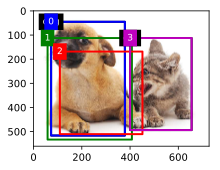

In [48]:
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,ground_truth[:,1:]*bbox_scale,['dog','cat'],'k')
show_bboxes(fig.axes,anchors*bbox_scale,['0','1','2','3','4']);

我们可以通过contrib.nd模块中的**MultiBoxTarget**函数来为锚框标注类别和偏移量。该函数将背景类别设为0，并令从零开始的目标类别的整数索引自加1（1为狗，2为猫）。我们通过expand_dims函数为锚框和真实边界框添加样本维，并构造形状为(批量大小, 包括背景的类别个数, 锚框数)的任意预测结果。

In [19]:
labels=contrib.nd.MultiBoxTarget(anchors.expand_dims(axis=0),ground_truth.expand_dims(axis=0),nd.zeros((1,3,5)))

In [20]:
labels

[
 [[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.40e+00  1.00e+01  2.59e+00
    7.18e+00 -1.20e+00  2.69e-01  1.68e+00 -1.57e+00  0.00e+00  0.00e+00
    0.00e+00  0.00e+00 -5.71e-01 -1.00e+00 -8.94e-07  6.26e-01]]
 <NDArray 1x20 @cpu(0)>, 
 [[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]]
 <NDArray 1x20 @cpu(0)>, 
 [[0. 1. 2. 0. 2.]]
 <NDArray 1x5 @cpu(0)>]

返回的结果里有3项，均为NDArray。第三项表示为锚框标注的类别。

In [22]:
labels[2]


[[0. 1. 2. 0. 2.]]
<NDArray 1x5 @cpu(0)>

我们根据锚框与真实边界框在图像中的位置来分析这些标注的类别。首先，在所有的“锚框—真实边界框”的配对中，锚框 $A_4$ 与猫的真实边界框的交并比最大，因此锚框 $A_4$ 的类别标注为猫。不考虑锚框 $A_4$ 或猫的真实边界框，在剩余的“锚框—真实边界框”的配对中，最大交并比的配对为锚框 $A_1$ 和狗的真实边界框，因此锚框 $A_1$ 的类别标注为狗。接下来遍历未标注的剩余3个锚框：与锚框 $A_0$ 交并比最大的真实边界框的类别为狗，但交并比小于阈值（默认为0.5），因此类别标注为背景；与锚框 $A_2$ 交并比最大的真实边界框的类别为猫，且交并比大于阈值，因此类别标注为猫；与锚框 $A_3$ 交并比最大的真实边界框的类别为猫，但交并比小于阈值，因此类别标注为背景。

返回值的第二项为掩码（mask）变量，形状为(批量大小, 锚框个数的四倍)。掩码变量中的元素与每个锚框的4个偏移量一一对应。 由于我们不关心对背景的检测，有关负类的偏移量不应影响目标函数。通过按元素乘法，掩码变量中的0可以在计算目标函数之前过滤掉负类的偏移量。

In [23]:
labels[1]


[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]]
<NDArray 1x20 @cpu(0)>

返回的第一项是为每个锚框标注的四个偏移量，其中负类锚框的偏移量标注为0。

In [25]:
labels[0]


[[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.40e+00  1.00e+01  2.59e+00
   7.18e+00 -1.20e+00  2.69e-01  1.68e+00 -1.57e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00 -5.71e-01 -1.00e+00 -8.94e-07  6.26e-01]]
<NDArray 1x20 @cpu(0)>

## 输出预测边界框
在模型预测阶段，我们先为图像生成多个锚框，并为这些锚框一一预测类别和偏移量。随后，我们根据锚框及其预测偏移量得到预测边界框。当锚框数量较多时，同一个目标上可能会输出较多相似的预测边界框。为了使结果更加简洁，我们可以移除相似的预测边界框。常用的方法叫作非极大值抑制（non-maximum suppression，NMS）。

我们来描述一下非极大值抑制的工作原理。对于一个预测边界框 B ，模型会计算各个类别的预测概率。设其中最大的预测概率为 p ，该概率所对应的类别即 B 的预测类别。我们也将 p 称为预测边界框 B 的置信度。在同一图像上，我们将预测类别非背景的预测边界框按置信度从高到低排序，得到列表 L 。从 L 中选取置信度最高的预测边界框 $B_1$ 作为基准，将所有与 $B_1$ 的交并比大于某阈值的非基准预测边界框从 L 中移除。这里的阈值是预先设定的超参数。此时， L 保留了置信度最高的预测边界框并移除了与其相似的其他预测边界框。 接下来，从 L 中选取置信度第二高的预测边界框 $B_2$ 作为基准，将所有与 $B_2$ 的交并比大于某阈值的非基准预测边界框从 L 中移除。重复这一过程，直到 L 中所有的预测边界框都曾作为基准。此时 L 中任意一对预测边界框的交并比都小于阈值。最终，输出列表 L 中的所有预测边界框。

下面来看一个具体的例子。先构造4个锚框。简单起见，我们假设预测偏移量全是0：预测边界框即锚框。最后，我们构造每个类别的预测概率。

In [26]:
anchors=nd.array([[0.1,0.08,0.52,0.92],
                 [0.08,0.2,0.56,0.95],
                 [0.15,0.3,0.62,0.91],
                 [0.55,0.2,0.9,0.88]])
offset_preds=nd.array([0]*anchors.size)
cls_probs=nd.array([[0]*4, #背景的预测值
                   [0.9,0.8,0.7,0.1],#狗的预测值
                   [0.1,0.2,0.3,0.9]])#猫的预测值

In [27]:
[1]*4

[1, 1, 1, 1]

In [47]:
[[1,2]]*4

[[1, 2], [1, 2], [1, 2], [1, 2]]

在图像上打印预测边界框和它们的置信度。

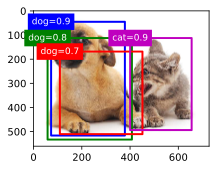

In [29]:
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,anchors*bbox_scale,['dog=0.9','dog=0.8','dog=0.7','cat=0.9'])

我们使用contrib.nd模块的**MultiBoxDetection**函数来执行非极大值抑制并设阈值为0.5。这里为NDArray输入都增加了样本维。我们看到，返回的结果的形状为(批量大小, 锚框个数, 6)。其中每一行的6个元素代表同一个预测边界框的输出信息。第一个元素是索引从0开始计数的预测类别（0为狗，1为猫），其中-1表示背景或在非极大值抑制中被移除。第二个元素是预测边界框的置信度。剩余的4个元素分别是预测边界框左上角的 x 和 y 轴坐标以及右下角的 x 和 y 轴坐标（值域在0到1之间）。

In [31]:
output=contrib.ndarray.MultiBoxDetection(cls_probs.expand_dims(axis=0),offset_preds.expand_dims(axis=0),
                                        anchors.expand_dims(axis=0),nms_threshold=0.5)
output


[[[ 0.    0.9   0.1   0.08  0.52  0.92]
  [ 1.    0.9   0.55  0.2   0.9   0.88]
  [-1.    0.8   0.08  0.2   0.56  0.95]
  [-1.    0.7   0.15  0.3   0.62  0.91]]]
<NDArray 1x4x6 @cpu(0)>

我们移除掉类别为-1的预测边界框，并可视化非极大值抑制保留的结果。

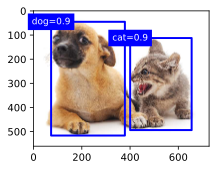

In [45]:
fig=d2l.plt.imshow(img)
for i in output[0].asnumpy():
    if i[0]==-1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes,[nd.array(i[2:])*bbox_scale],label);

实践中，我们可以在执行非极大值抑制前将置信度较低的预测边界框移除，从而减小非极大值抑制的计算量。我们还可以筛选非极大值抑制的输出，例如，只保留其中置信度较高的结果作为最终输出。

In [41]:
label = ('dog=', 'cat=')[0] + str(0.9)
label

'dog=0.9'

## 小结
* 以每个像素为中心，生成多个大小和宽高比不同的锚框。mxnet.contrib.ndarry.MultiBoxPrior()实现
* 交并比是两个边界框相交面积与相并面积之比。
* 在训练集中，为每个锚框标注两类标签：一是锚框所含目标的类别；二是真实边界框相对锚框的偏移量。MultiBoxTarget()实现
* 预测时，可以使用非极大值抑制来移除相似的预测边界框，从而令结果简洁。MultiBoxDetection()实现

In [46]:
[[1,2]]*4

[[1, 2], [1, 2], [1, 2], [1, 2]]

# 多尺度目标检测
在“锚框”一节中，我们在实验中以输入图像的每个像素为中心生成多个锚框。这些锚框是对输入图像不同区域的采样。然而，如果以图像每个像素为中心都生成锚框，很容易生成过多锚框而造成计算量过大。举个例子，假设输入图像的高和宽分别为561像素和728像素，如果以每个像素为中心生成5个不同形状的锚框，那么一张图像上则需要标注并预测200多万个锚框（ 561×728×5 ）。

减少锚框个数并不难。一种简单的方法是在输入图像中均匀采样一小部分像素，并以采样的像素为中心生成锚框。此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。值得注意的是，较小目标比较大目标在图像上出现位置的可能性更多。举个简单的例子：形状为 1×1 、 1×2 和 2×2 的目标在形状为 2×2 的图像上可能出现的位置分别有4、2和1种。因此，当使用较小锚框来检测较小目标时，我们可以采样较多的区域；而当使用较大锚框来检测较大目标时，我们可以采样较少的区域。

为了演示如何多尺度生成锚框，我们先读取一张图像。它的高和宽分别为561像素和728像素。

In [1]:
import d2lzh as d2l
from mxnet import contrib,image,nd
%matplotlib inline

In [15]:
img=image.imread('./img/catdog.jpg')
h,w=img.shape[:2]
h,w #行数，列数

(561, 728)

我们在“二维卷积层”一节中将卷积神经网络的二维数组输出称为特征图。 我们可以通过定义特征图的形状来确定任一图像上均匀采样的锚框中心。

下面定义display_anchors函数。我们在特征图fmap上以每个单元（像素）为中心生成锚框anchors。由于锚框anchors中 x 和 y 轴的坐标值分别已除以特征图fmap的宽和高，这些值域在0和1之间的值表达了锚框在特征图中的相对位置。由于锚框anchors的中心遍布特征图fmap上的所有单元，anchors的中心在任一图像的空间相对位置一定是均匀分布的。具体来说，当特征图的宽和高分别设为fmap_w和fmap_h时，该函数将在任一图像上均匀采样fmap_h行fmap_w列个像素，并分别以它们为中心生成大小为s（假设列表s长度为1）的不同宽高比（ratios）的锚框。

In [8]:
d2l.set_figsize()

def display_anchors(fmap_w,fmap_h,s):
    fmap=nd.zeros((1,10,fmap_w,fmap_h)) # 前两维的取值不影响输出结果
    anchors=contrib.nd.MultiBoxPrior(fmap,sizes=s,ratios=[1,2,0.5])# fmap: batchnum,channels,height,wight
    bbox_scale=nd.array([w,h,w,h])
    d2l.show_bboxes(d2l.plt.imshow(img.asnumpy()).axes,anchors[0]*bbox_scale)

我们先关注小目标的检测。为了在显示时更容易分辨，这里令不同中心的锚框不重合：设锚框大小为0.15，特征图的高和宽分别为4。可以看出，图像上4行4列的锚框中心分布均匀。

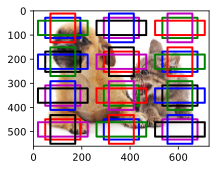

In [12]:
display_anchors(4,3,s=[0.15])

我们将特征图的高和宽分别减半，并用更大的锚框检测更大的目标。当锚框大小设0.4时，有些锚框的区域有重合。

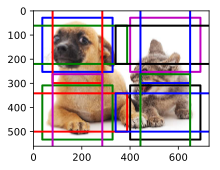

In [14]:
display_anchors(2,2,s=[0.4])

最后，我们将特征图的高和宽进一步减半至1，并将锚框大小增至0.8。此时锚框中心即图像中心。

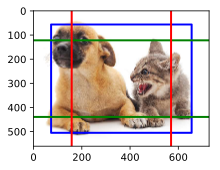

In [11]:
display_anchors(1,1,s=[0.8])

既然我们已在多个尺度上生成了不同大小的锚框，相应地，我们需要在不同尺度下检测不同大小的目标。下面我们来介绍一种基于卷积神经网络的方法。

在某个尺度下，假设我们依据 $c_i$ 张形状为 h×w 的特征图生成 h×w 组不同中心的锚框，且每组的锚框个数为 a 。例如，在刚才实验的第一个尺度下，我们依据10（通道数）张形状为 4×4 的特征图生成了16组不同中心的锚框，且每组含3个锚框。 接下来，依据真实边界框的类别和位置，每个锚框将被标注类别和偏移量。在当前的尺度下，目标检测模型需要根据输入图像预测 h×w 组不同中心的锚框的类别和偏移量。

假设这里的 $c_i$ 张特征图为卷积神经网络根据输入图像做前向计算所得的中间输出。既然每张特征图上都有 h×w 个不同的空间位置，那么相同空间位置可以看作含有 $c_i$ 个单元。 根据“二维卷积层”一节中感受野的定义，特征图在相同空间位置的 $c_i$ 个单元在输入图像上的感受野相同，并表征了同一感受野内的输入图像信息。 因此，我们可以将特征图在相同空间位置的 $c_i$ 个单元变换为以该位置为中心生成的 a 个锚框的类别和偏移量。 不难发现，本质上，我们用输入图像在某个感受野区域内的信息来预测输入图像上与该区域位置相近的锚框的类别和偏移量。

当不同层的特征图在输入图像上分别拥有不同大小的感受野时，它们将分别用来检测不同大小的目标。例如，我们可以通过设计网络，令较接近输出层的特征图中每个单元拥有更广阔的感受野，从而检测输入图像中更大尺寸的目标。

我们将在“单发多框检测（SSD）”一节具体实现一个多尺度目标检测的模型。

## 小结
* 可以在多个尺度下生成不同数量和大小的锚框，从而在多个尺度下检测不同大小的目标
* 特征图的形状能确定任一图像上均匀采样的锚框中心
* 用输入图像在某个感受野区域内的信息来预测输入图像上与该区域相近的锚框的类别和偏移量。

# 目标检测数据集（皮卡丘）
在目标检测领域并没有类似MNIST或Fashion-MNIST那样的小数据集。为了快速测试模型，我们合成了一个小的数据集。我们首先使用一个开源的皮卡丘3D模型生成了1000张不同角度和大小的皮卡丘图像。然后我们收集了一系列背景图像，并在每张图的随机位置放置一张随机的皮卡丘图像。我们使用MXNet提供的im2rec工具将图像转换成二进制的RecordIO格式 [1]。该格式既可以降低数据集在磁盘上的存储开销，又能提高读取效率。如果想了解更多的图像读取方法，可以查阅GluonCV工具包的文档 [2]。

## 下载数据集
RecordIO格式的皮卡丘数据集可以直接在网上下载。下载数据集的操作定义在\_download\_pikachu函数中。

In [16]:
import d2lzh as d2l
from mxnet import gluon,image
from mxnet.gluon import utils as gutils
import os
%matplotlib inline

In [17]:
def _download_pikachu(data_dir):
    root_url=('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset={'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k,v in dataset.items():
        gutils.download(root_url+k,os.path.join(data_dir,k),sha1_hash=v)

## 读取数据集
我们通过创建ImageDetIter实例来读取目标检测数据集。其中名称里的“Det”指的是Detection（检测）。我们将以随机顺序读取训练数据集。由于数据集的格式为RecordIO，我们需要提供图像索引文件train.idx以随机读取小批量。此外，对于训练集中的每张图像，我们将采用随机裁剪，并要求裁剪出的图像至少覆盖每个目标95%的区域。由于裁剪是随机的，这个要求不一定总被满足。我们设定最多尝试200次随机裁剪：如果都不符合要求则不裁剪图像。为保证输出结果的确定性，我们不随机裁剪测试数据集中的图像。我们也无须按随机顺序读取测试数据集。

In [18]:
def load_data_pikachu(batch_size,edge_size=256):#edge_size:输出图片的宽和高
    data_dir='./data/pikachu'
    _download_pikachu(data_dir)
    train_iter=image.ImageDetIter(path_imgrec=os.path.join(data_dir,'train.rec'),
                                 path_imgidx=os.path.join(data_dir,'train.idx'),
                                 batch_size=batch_size,
                                  data_shape=(3,edge_size,edge_size),
                                 shuffle=True,# 以随机顺序读取数据集
                                  rand_crop=1,# 随机裁剪的概率为1
                                  min_object_covered=0.95,
                                  max_attempts=200
                                 )
    val_iter=image.ImageDetIter(path_imgrec=os.path.join(data_dir,'val.rec'),
                               batch_size=batch_size,
                               data_shape=(3,edge_size,edge_size),
                               shuffle=False)
    return train_iter,val_iter

下面我们读取一个小批量并打印图像和标签的形状。图像的形状和之前实验中的一样，依然是(批量大小, 通道数, 高, 宽)。而标签的形状则是(批量大小, m, 5)，其中m等于数据集中单个图像最多含有的边界框个数。小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。由于每张图像含有的边界框个数可能不同，我们为边界框个数小于m的图像填充非法边界框，直到每张图像均含有m个边界框。这样，我们就可以每次读取小批量的图像了。图像中每个边界框的标签由长度为5的数组表示。数组中第一个元素是边界框所含目标的类别。当值为-1时，该边界框为填充用的非法边界框。数组的剩余4个元素分别表示边界框左上角的x和y轴坐标以及右下角的x和y轴坐标（值域在0到1之间）。这里的皮卡丘数据集中每个图像只有一个边界框，因此m=1。

In [19]:
batch_size,edge_size=32,256
train_iter,_=load_data_pikachu(batch_size,edge_size)
batch=train_iter.next()
batch.data[0].shape,batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

## 图示数据
我们画出10张图像和它们中的边界框。可以看到，皮卡丘的角度、大小和位置在每张图像中都不一样。当然，这是一个简单的人工数据集。实际中的数据通常会复杂得多。

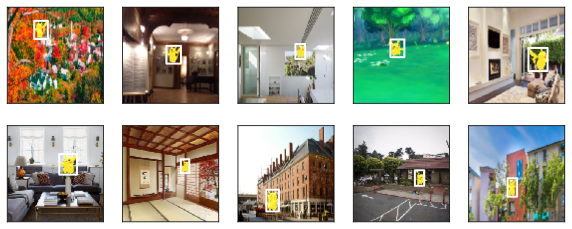

In [31]:
imgs=(batch.data[0][0:10].transpose((0,2,3,1)));
imgs/=255.
axes=d2l.show_images(imgs,2,5).flatten()
for ax,label in zip(axes,batch.label[0][0:10]):
    d2l.show_bboxes(ax,[label[0][1:5]*edge_size],colors=['w'])

## 小结
* 合成的皮卡丘数据集可用于测试目标检测模型。
* 目标检测的数据读取跟图像分类的类似。然而，在引入边界框后，标签形状和图像增广（如随机裁剪）发生了变化。

# 单发多框检测(SSD)
SSD:single shot multibox detection

## 模型
图9.4描述了单发多框检测模型的设计。它主要由一个基础网络块和若干个多尺度特征块串联而成。其中基础网络块用来从原始图像中抽取特征，因此一般会选择常用的深度卷积神经网络。单发多框检测论文中选用了在分类层之前截断的VGG [1]，现在也常用ResNet替代。我们可以设计基础网络，使它输出的高和宽较大。这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。如此一来，图9.4中越靠近顶部的多尺度特征块输出的特征图越小，故而基于特征图生成的锚框也越少，加之特征图中每个单元感受野越大，因此更适合检测尺寸较大的目标。由于单发多框检测基于**基础网络块**和各个**多尺度特征块**生成不同数量和不同大小的锚框，并通过预测锚框的类别和偏移量（即预测边界框）检测不同大小的目标，因此单发多框检测是一个**多尺度的目标检测模型**。

图 9.4 单发多框检测模型主要由一个基础网络块和若干多尺度特征块串联而成

![](http://zh.d2l.ai/_images/ssd.svg)

接下来我们介绍如何实现图中的各个模块。我们先介绍如何实现类别预测和边界框预测。

### 类别预测层
设目标的类别个数为q。每个锚框的类别个数将是q+1，其中类别0表示锚框只包含背景。在某个尺度下，设特征图的高和宽分别为h和w，如果以其中每个单元为中心生成a个锚框，那么我们需要对hwa个锚框进行分类。如果使用全连接层作为输出，很容易导致模型参数过多。回忆“网络中的网络（NiN）”一节介绍的使用卷积层的通道来输出类别预测的方法。单发多框检测采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高和宽的卷积层。这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。考虑输出和输入同一空间坐标(x,y)：输出特征图上(x,y)坐标的通道里包含了以输入特征图(x,y)坐标为中心生成的所有锚框的类别预测。因此输出通道数为a(q+1)，其中索引为i(q+1)+j（0≤j≤q）的通道代表了索引为i的锚框有关类别索引为j的预测。

下面我们定义一个这样的类别预测层：指定参数a和q后，它使用一个填充为1的3×3卷积层。该卷积层的输入和输出的高和宽保持不变。

In [2]:
import d2lzh as d2l
from mxnet import gluon,autograd,contrib,image,init,nd
from mxnet.gluon import loss as gloss,nn
%matplotlib inline
import time

In [3]:
def cls_predictor(num_anchors,num_classes):
    return nn.Conv2D(num_anchors*(num_classes+1),kernel_size=3,padding=1)

### 边界框预测层

边界框预测层的设计与类别预测层的设计类似。唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是q+1个类别。

In [4]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors*4,kernel_size=3,padding=1)

### 连接多尺度的预测 

前面提到，单发多框检测根据多个尺度下的特征图生成锚框并预测类别和偏移量。由于每个尺度上特征图的形状或以同一单元为中心生成的锚框个数都可能不同，因此不同尺度的预测输出形状可能不同。

在下面的例子中，我们对同一批量数据构造两个不同尺度下的特征图Y1和Y2，其中Y2相对于Y1来说高和宽分别减半。以类别预测为例，假设以Y1和Y2特征图中每个单元生成的锚框个数分别是5和3，当目标类别个数为10时，类别预测输出的通道数分别为5×(10+1)=55和3×(10+1)=33。预测输出的格式为(批量大小, 通道数, 高, 宽)。可以看到，除了批量大小外，其他维度大小均不一样。我们需要将它们变形成统一的格式并将多尺度的预测连结，从而让后续计算更简单。

In [5]:
def forward(x,block):
    block.initialize()
    return block(x)

Y1=forward(nd.zeros((2,8,20,20)),cls_predictor(5,10))
Y2=forward(nd.zeros((2,16,10,10)),cls_predictor(3,10))
Y1.shape,Y2.shape

((2, 55, 20, 20), (2, 33, 10, 10))

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的(批量大小, 高×宽×通道数)的格式，以方便之后在维度1上的连结。

如图样本数为1，通道为2的2*2数据：

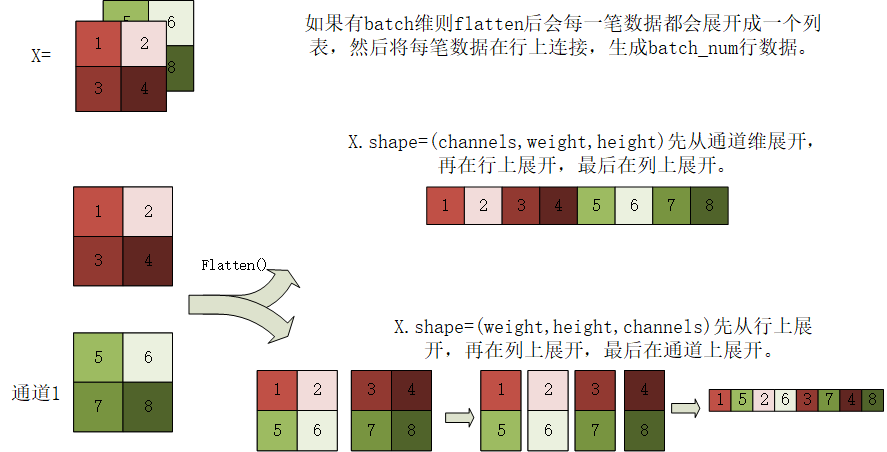


In [6]:
def flatten_pred(pred):
    return pred.transpose((0,2,3,1)).flatten()

def concat_pred(preds):
    return nd.concat(*[flatten_pred(p) for p in preds],dim=1)

这样一来，尽管Y1和Y2形状不同，我们仍然可以将这两个同一批量不同尺度的预测结果连结在一起。

In [7]:
concat_pred([Y1,Y2]).shape

(2, 25300)

In [8]:
X=nd.array([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]])
X,X.shape

(
 [[[ 1.  2.  3.]
   [ 4.  5.  6.]]
 
  [[ 7.  8.  9.]
   [10. 11. 12.]]]
 <NDArray 2x2x3 @cpu(0)>, (2, 2, 3))

In [9]:
Y=X.flatten()
Y


[[ 1.  2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11. 12.]]
<NDArray 2x6 @cpu(0)>

In [10]:
X.transpose((1,2,0))


[[[ 1.  7.]
  [ 2.  8.]
  [ 3.  9.]]

 [[ 4. 10.]
  [ 5. 11.]
  [ 6. 12.]]]
<NDArray 2x3x2 @cpu(0)>

In [11]:
X.transpose((1,2,0)).flatten()


[[ 1.  7.  2.  8.  3.  9.]
 [ 4. 10.  5. 11.  6. 12.]]
<NDArray 2x6 @cpu(0)>

### 高宽减半块
为了在多尺度检测目标，下面定义高和宽减半块down_sample_blk。它串联了两个填充为1的 3×3 卷积层和步幅为2的 2×2 最大池化层。我们知道，填充为1的 3×3 卷积层不改变特征图的形状，而后面的池化层则直接将特征图的高和宽减半。由于 1×2+(3−1)+(3−1)=6 ，输出特征图中每个单元在输入特征图上的感受野形状为 6×6 。可以看出，高和宽减半块使输出特征图中每个单元的感受野变得更广阔。

In [12]:
def dowm_sample_blk(num_channels):
    blk=nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels,kernel_size=3,padding=1))
        blk.add(nn.BatchNorm())
        blk.add(nn.Activation('relu'))
    blk.add(nn.MaxPool2D(pool_size=2,strides=2))
    return blk

测试高和宽减半块的前向计算。可以看到，它改变了输入的通道数，并将高和宽减半。


In [13]:
forward(nd.zeros((2,3,20,20)),dowm_sample_blk(10)).shape

(2, 10, 10, 10)

### 基础网络块
基础网络块用来从原始图像中抽取特征。为了计算简洁，我们在这里构造一个小的基础网络。该网络串联3个高和宽减半块，并逐步将通道数翻倍。当输入的原始图像的形状为256×256时，基础网络块输出的特征图的形状为32×32。

In [14]:
def base_net():
    blk=nn.Sequential()
    for num_filters in [16,32,64]:
        blk.add(dowm_sample_blk(num_filters))
    return blk

In [15]:
forward(nd.zeros((2,3,256,256)),base_net()).shape

(2, 64, 32, 32)

### 完整的模型
单发多框检测模型一共包含5个模块，每个模块输出的特征图既用来生成锚框，又用来预测这些锚框的类别和偏移量。第一模块为基础网络块，第二模块至第四模块为高和宽减半块，第五模块使用全局最大池化层将高和宽降到1。因此第二模块至第五模块均为图9.4中的多尺度特征块。

In [16]:
def get_blk(i):
    if i==0:
        blk=base_net()
    elif i==4:
        blk=nn.GlobalAvgPool2D()
    else:
        blk=dowm_sample_blk(128)
    return blk

接下来，我们定义每个模块如何进行前向计算。跟之前介绍的卷积神经网络不同，这里不仅返回卷积计算输出的特征图Y，还返回根据Y生成的当前尺度的锚框，以及基于Y预测的锚框类别和偏移量。

In [17]:
def blk_forward(X,blk,size,ratio,cls_predictor,bbox_predictor):
    Y=blk(X)
    anchors=contrib.nd.MultiBoxPrior(Y,sizes=size,ratios=ratio)
    cls_preds=cls_predictor(Y)#类别预测层输出
    bbox_preds=bbox_predictor(Y)#边界框预测层输出
    return (Y,anchors,cls_preds,bbox_preds)

我们提到，图9.4中较靠近顶部的多尺度特征块用来检测尺寸较大的目标，因此需要生成较大的锚框。我们在这里先将0.2到1.05之间均分5份，以确定不同尺度下锚框大小的较小值0.2、0.37、0.54等，再按 $\sqrt{0.2×0.37}=0.272 、\sqrt{0.37×0.54}=0.447$ 等来确定不同尺度下锚框大小的较大值。

In [18]:
sizes=[[0.2,0.272],[0.37,0.447],[0.54,0.619],[0.71,0.79],[0.88,0.961]]

In [19]:
ratios=[[1,2,0.5]]*5
num_anchors=len(sizes[0])+len(ratios[0])-1

定义出完整的模型TinySSD了。

In [20]:
class TinySSD(nn.Block):
    def __init__(self,num_classes,**kwargs):
        super(TinySSD,self).__init__(**kwargs)
        self.num_classes=num_classes
        for i in range(5):
            setattr(self,'blk_%d' % i ,get_blk(i))
            setattr(self,'cls_%d' %i,cls_predictor(num_anchors,num_classes))
            setattr(self,'bbox_%d' % i,bbox_predictor(num_anchors))
    
    def forward(self,X):
        anchors,cls_preds,bbox_preds=[None]*5,[None]*5,[None]*5
        for i in range(5):
            X,anchors[i],cls_preds[i],bbox_preds[i]=blk_forward(X,
                                                               getattr(self,'blk_%d' % i),
                                                               sizes[i],
                                                               ratios[i],
                                                               getattr(self,'cls_%d' % i),
                                                               getattr(self,"bbox_%d" % i))
        # reshape函数中的0表示保持批量大小不变
    
        return (nd.concat(*anchors,dim=1),concat_pred(cls_preds).reshape(0,-1,self.num_classes+1),concat_pred(bbox_preds))

我们创建单发多框检测模型实例并对一个高和宽均为256像素的小批量图像X做前向计算。我们在之前验证过，第一模块输出的特征图的形状为 32×32 。由于第二至第四模块为高和宽减半块、第五模块为全局池化层，并且以特征图每个单元为中心生成4个锚框，每个图像在5个尺度下生成的锚框总数为 $(32^2+16^2+8^2+4^2+1)×4=5444$ 。

In [34]:
net=TinySSD(num_classes=1)
net.initialize()
X=nd.zeros((32,3,256,256))
anchors,cls_preds,bbox_preds=net(X)
print('output anchors: ',anchors.shape)
print('output class preds: ',cls_preds.shape)
print('output bbox preds: ',bbox_preds.shape)

output anchors:  (1, 5444, 4)
output class preds:  (32, 5444, 2)
output bbox preds:  (32, 21776)


## 训练


### 读取数据和初始化

In [35]:
batch_size=32
train_iter,val_iter=d2l.load_data_pikachu(batch_size)

在皮卡丘数据集中，目标的类别数为1。定义好模型以后，我们需要初始化模型参数并定义优化算法。

In [40]:
ctx,net=d2l.try_gpu(),TinySSD(1)
net.initialize(init=init.Xavier(),ctx=ctx)
trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.2,'wd':5e-4})

### 定义损失函数和评价函数
目标检测有两个损失：一是有关锚框类别的损失，我们可以重用之前图像分类问题里一直使用的交叉熵损失函数；二是有关正类锚框偏移量的损失。预测偏移量是一个回归问题，但这里不使用前面介绍过的平方损失，而使用 L1 范数损失，即预测值与真实值之间差的绝对值。掩码变量bbox_masks令负类锚框和填充锚框不参与损失的计算。最后，我们将有关锚框类别和偏移量的损失相加得到模型的最终损失函数。

In [41]:
cls_loss=gloss.SoftmaxCrossEntropyLoss()
bbox_loss=gloss.L1Loss()

def calc_loss(cls_preds,cls_labels,bbox_preds,bbox_labels,bbox_masks):
    cls=cls_loss(cls_preds,cls_labels)
    bbox=bbox_loss(bbox_preds*bbox_masks,bbox_labels*bbox_masks)
    return cls+bbox

我们可以沿用准确率评价分类结果。因为使用了 L1 范数损失，我们用平均绝对误差评价边界框的预测结果。

In [44]:
def cls_eval(cls_preds,cls_labels):
    return (cls_preds.argmax(axis=-1)==cls_labels).sum().asscalar()

def bbox_eval(bbox_preds,bbox_labels,bbox_masks):
    return ((bbox_preds-bbox_labels)*bbox_masks).abs().sum().asscalar()

### 训练模型
在训练模型时，我们需要在模型的前向计算过程中生成多尺度的锚框anchors，并为每个锚框预测类别cls_preds和偏移量bbox_preds。之后，我们根据标签信息Y为生成的每个锚框标注类别cls_labels和偏移量bbox_labels。最后，我们根据类别和偏移量的预测和标注值计算损失函数。为了代码简洁，这里没有评价测试数据集。

In [45]:
for epoch in range(20):
    acc_sum,mae_sum,n,m=0.0,0.0,0,0
    train_iter.reset()
    start=time.time()
    for batch in train_iter:
        X=batch.data[0].as_in_context(ctx)
        Y=batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors,cls_preds,bbox_preds=net(X)
             # 为每个锚框标注类别和偏移量
            bbox_labels,bbox_masks,cls_labels=contrib.nd.MultiBoxTarget(anchors,Y,cls_preds.transpose((0,2,1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l=calc_loss(cls_preds,cls_labels,bbox_preds,bbox_labels,bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum+=cls_eval(cls_preds,cls_labels)
        n+=cls_labels.size
        mae_sum+=bbox_eval(bbox_preds,bbox_labels,bbox_masks)
        m+=bbox_labels.size
        
    if (epoch+1) % 5==0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

epoch  5, class err 2.86e-03, bbox mae 3.24e-03, time 24.5 sec
epoch 10, class err 2.62e-03, bbox mae 3.01e-03, time 24.7 sec
epoch 15, class err 2.57e-03, bbox mae 2.98e-03, time 25.1 sec
epoch 20, class err 2.40e-03, bbox mae 2.64e-03, time 25.0 sec


## 预测
在预测阶段，我们希望能把图像里面所有我们感兴趣的目标检测出来。下面读取测试图像，将其变换尺寸，然后转成卷积层需要的四维格式。

In [49]:
img=image.imread('./img/pikachu.jpg')
feature=image.imresize(img,256,256).astype('float32')
X=feature.transpose((2,0,1)).expand_dims(axis=0)

我们通过MultiBoxDetection函数根据锚框及其预测偏移量得到预测边界框，并通过非极大值抑制移除相似的预测边界框。

In [50]:
def predict(X):
    anchors,cls_preds,bbox_preds=net(X.as_in_context(ctx))
    cls_probs=cls_preds.softmax().transpose((0,2,1))
    output=contrib.nd.MultiBoxDetection(cls_probs,bbox_preds,anchors)
    idx=[i for i,row in enumerate(output[0]) if row[0].asscalar()!=-1]#去掉负类
    return output[0,idx]

output=predict(X)

最后，我们将置信度不低于0.3的边界框筛选为最终输出用以展示。

In [54]:
d2l.set_figsize((5,5))

def display(img,output,threshold):
    fig=d2l.plt.imshow(img.asnumpy())
    for row in output:
        score=row[1].asscalar()
        if score<threshold:
            continue
        h,w=img.shape[0:2]
        bbox=[row[2:6]*nd.array((w,h,w,h),ctx=row.context)]
        d2l.show_bboxes(fig.axes,bbox,"%.2f" % score,'w')

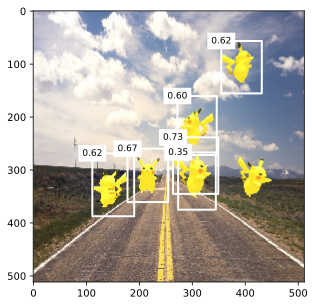

In [58]:
display(img,output,0.3)

## 小结
* 单发多框检测是一个多尺度的目标检测模型。该模型基于基础网络块和各个多尺度特征块生成不同数量和不同大小的锚框，并通过预测锚框的类别和偏移量检测不同大小的目标。
* 单发多框检测在训练中根据类别和偏移量的预测和标注值计算损失函数。

## 练习
实验中忽略了单发多框检测的一些实现细节。

### 损失函数

将预测偏移量用到的 L1 范数损失替换为平滑 L1 范数损失。它在零点附近使用平方函数从而更加平滑，这是通过一个超参数 σ 来控制平滑区域的：
$$ f(x)=\begin{cases}
(\sigma x)^2/2 & |x|<1/\sigma^2 \\
|x|-0.5/\sigma^2 & otherwise 
\end{cases}$$
 
当 σ 很大时该损失类似于 L1 范数损失。当它较小时，损失函数较平滑。

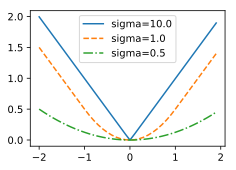

In [59]:
sigmas=[10,1,0.5]
lines=['-','--','-.']
x=nd.arange(-2,2,0.1)
d2l.set_figsize()
for l,s in zip(lines,sigmas):
    y=nd.smooth_l1(x,scalar=s)
    d2l.plt.plot(x.asnumpy(),y.asnumpy(),l,label='sigma=%.1f' % s)
d2l.plt.legend()

在类别预测时，实验中使用了交叉熵损失：设真实类别 j 的预测概率是 pj ，交叉熵损失为 $−logp_j$ 。我们还可以使用焦点损失（focal loss）[2]：给定正的超参数 γ 和 α ，该损失的定义为

$−α(1−p_j)^γlogp_j$.
 
可以看到，增大 γ 可以有效减小正类预测概率较大时的损失。

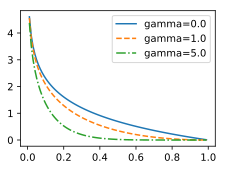

In [60]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * x.log()

x = nd.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x.asnumpy(), focal_loss(gamma, x).asnumpy(), l,
                     label='gamma=%.1f' % gamma)
d2l.plt.legend();

### 预测和训练
* 当目标在图像中占比较小时，模型通常会采用比较大的输入图像尺寸。
* 为锚框标注类别时，通常会产生大量的负类锚框。可以对负类锚框进行采样，从而使数据类别更加平衡。这个可以通过设置MultiBoxTarget函数的negative_mining_ratio参数来完成。
* 在损失函数中为有关锚框类别和有关正类锚框偏移量的损失分别赋予不同的权重超参数。
* 参考单发多框检测论文，还有哪些方法可以评价目标检测模型的精度 [1]？

关于nd.reshape()

In [29]:
nd.array([[1,2,3,4,5,6,7,8,9],[10,11,12,13,14,15,16,17,18]]).reshape(0,-1,2)#=0表示第0维大小保持不变


[[[ 1.  2.]
  [ 3.  4.]
  [ 5.  6.]
  [ 7.  8.]]

 [[ 9. 10.]
  [11. 12.]
  [13. 14.]
  [15. 16.]]]
<NDArray 2x4x2 @cpu(0)>

In [27]:
nd.array([[[1,2,3],[4,5,6],[7,8,9]],[[10,11,12],[13,14,15],[16,17,18]]]).reshape(0,-1,2)


[[[ 1.  2.]
  [ 3.  4.]
  [ 5.  6.]
  [ 7.  8.]]

 [[ 9. 10.]
  [11. 12.]
  [13. 14.]
  [15. 16.]]]
<NDArray 2x4x2 @cpu(0)>

In [28]:
nd.reshape??

Some dimensions of the shape can take special values from the set {0, -1, -2, -3, -4}. The significance of each is explained below:

- ``0``  copy this dimension from the input to the output shape.

  Example::

  - input shape = (2,3,4), shape = (4,0,2), output shape = (4,3,2)
  - input shape = (2,3,4), shape = (2,0,0), output shape = (2,3,4)

- ``-1`` infers the dimension of the output shape by using the remainder of the input dimensions
  keeping the size of the new array same as that of the input array.
  At most one dimension of shape can be -1.

  Example::

  - input shape = (2,3,4), shape = (6,1,-1), output shape = (6,1,4)
  - input shape = (2,3,4), shape = (3,-1,8), output shape = (3,1,8)
  - input shape = (2,3,4), shape=(-1,), output shape = (24,)

- ``-2`` copy all/remainder of the input dimensions to the output shape.

  Example::

  - input shape = (2,3,4), shape = (-2,), output shape = (2,3,4)
  - input shape = (2,3,4), shape = (2,-2), output shape = (2,3,4)
  - input shape = (2,3,4), shape = (-2,1,1), output shape = (2,3,4,1,1)

- ``-3`` use the product of two consecutive dimensions of the input shape as the output dimension.

  Example::

  - input shape = (2,3,4), shape = (-3,4), output shape = (6,4)
  - input shape = (2,3,4,5), shape = (-3,-3), output shape = (6,20)
  - input shape = (2,3,4), shape = (0,-3), output shape = (2,12)
  - input shape = (2,3,4), shape = (-3,-2), output shape = (6,4)

- ``-4`` split one dimension of the input into two dimensions passed subsequent to -4 in shape (can contain -1).

  Example::

  - input shape = (2,3,4), shape = (-4,1,2,-2), output shape =(1,2,3,4)
  - input shape = (2,3,4), shape = (2,-4,-1,3,-2), output shape = (2,1,3,4)


nd.argmax()

In [33]:
nd.array([[[1,2,3],[4,5,6]],[[3,5,7],[9,1,0]]]).argmax(axis=-1)# axis为几就在哪个维度上比较大小，并取该维度的最大索引


[[2. 2.]
 [2. 0.]]
<NDArray 2x2 @cpu(0)>

In [35]:
contrib.nd.MultiBoxPrior??

# 语义分割和数据集

## Pascal VOC2012语义分割数据集
语义分割的一个重要数据集叫作Pascal VOC2012 [1]。为了更好地了解这个数据集，我们先导入实验所需的包或模块

In [2]:
import d2lzh as d2l
from mxnet import gluon,image,nd
from mxnet.gluon import data as gdata,utils as gutils
import os
import sys
import tarfile
%matplotlib inline

我们下载这个数据集的压缩包到./data路径下。压缩包大小是2 GB左右，下载需要一定时间。解压之后的数据集将会放置在./data/VOCdevkit/VOC2012路径下。

In [4]:
def dowmload_voc_pascal(data_dir='./data'):
    voc_dir=os.path.join(data_dir,'VOCdevkit/VOC2012')
    url= ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
           '/VOCtrainval_11-May-2012.tar')
    sha1='4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
    fname=gutils.download(url,data_dir,sha1_hash=sha1)
    with tarfile.open(fname,'r') as f:
        f.extractall(data_dir)
    return voc_dir
#voc_dir=dowmload_voc_pascal()

进入./data/VOCdevkit/VOC2012路径后，我们可以获取数据集的不同组成部分。其中ImageSets/Segmentation路径包含了指定训练和测试样本的文本文件，而JPEGImages和SegmentationClass路径下分别包含了样本的输入图像和标签。这里的标签也是图像格式，其尺寸和它所标注的输入图像的尺寸相同。标签中颜色相同的像素属于同一个语义类别。下面定义read_voc_images函数将输入图像和标签全部读进内存。

In [5]:
voc_dir='./data/VOCdevkit/VOC2012'
def read_voc_images(root=voc_dir,is_train=True):
    txt_fname='%s/ImageSets/Segmentation/%s' % (root,'train.txt' if is_train else 'val.txt')
    with open(txt_fname,'r') as f:
        images=f.read().split()
        features,labels=[None]*len(images),[None]*len(images)
        for i,fname in enumerate(images):
            features[i]=image.imread('%s/JPEGImages/%s.jpg' % (root,fname))
            labels[i]=image.imread('%s/SegmentationClass/%s.png' % (root,fname))
        return features,labels

In [6]:
train_features,train_labels=read_voc_images()

我们画出前5张输入图像和它们的标签。在标签图像中，白色和黑色分别代表边框和背景，而其他不同的颜色则对应不同的类别。

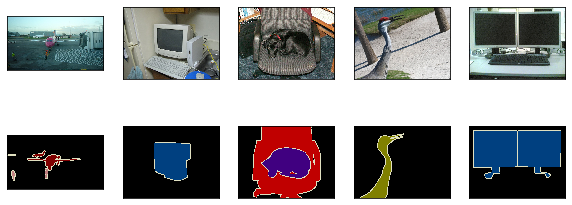

In [8]:
n=5
imgs=train_features[:n]+train_labels[:n]
d2l.show_images(imgs,2,n);

接下来，我们列出标签中每个RGB颜色的值及其标注的类别。

In [9]:
VOC_COLORMAP= [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES=['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

有了上面定义的两个常量以后，我们可以很容易地查找标签中每个像素的类别索引。

In [14]:
colormap2label=nd.zeros(256**3)#RGB立方空间拉直
for i,colormap in enumerate(VOC_COLORMAP): 
    colormap2label[(colormap[0]*256+colormap[1])*256+colormap[2]]=i #RGB为立方空间坐标点，找到该点在一维上的索引，在赋值类别。
    
def voc_label_indices(colormap,colormap2label):
    colormap=colormap.astype('int32')
    idx=((colormap[:,:,0]*256+colormap[:,:,1])*256+colormap[:,:,2]) #提取图像RGB并转化为一维索引
    return colormap2label[idx]

例如，第一张样本图像中飞机头部区域的类别索引为1，而背景全是0。

In [15]:
y=voc_label_indices(train_labels[0],colormap2label)
y[105:115,130:140],VOC_CLASSES[1]

(
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 <NDArray 10x10 @cpu(0)>, 'aeroplane')

In [20]:
nd.zeros(3**3)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
<NDArray 27 @cpu(0)>

In [21]:
nd.zeros(3**3)[nd.arange(9).reshape((3,3))]


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
<NDArray 3x3 @cpu(0)>

### 预处理数据
在之前的章节中，我们通过缩放图像使其符合模型的输入形状。然而在语义分割里，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。这样的映射难以做到精确，尤其在不同语义的分割区域。为了避免这个问题，我们将图像裁剪成固定尺寸而不是缩放。具体来说，我们使用图像增广里的随机裁剪，并对输入图像和标签裁剪相同区域。


In [16]:
def voc_rand_crop(feature,label,height,width):
    feature,rect=image.random_crop(feature,(width,height))
    label=image.fixed_crop(label,*rect)
    return feature,label

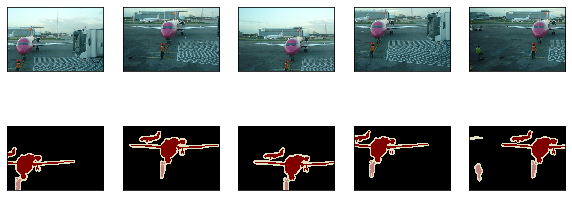

In [18]:
imgs=[]
for _ in range(n):
    imgs+=voc_rand_crop(train_features[0],train_labels[0],200,300)
d2l.show_images(imgs[::2]+imgs[1::2],2,n);#[::2]表示从头到尾，选择，步长为2，[1::2]表示从索引1开始到结尾，步长为2

### 自定义语义分割数据集类
我们通过继承Gluon提供的Dataset类自定义了一个语义分割数据集类VOCSegDataset。通过实现\_\_getitem\_\_函数，我们可以任意访问数据集中索引为idx的输入图像及其每个像素的类别索引。由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本需要通过自定义的filter函数所移除。此外，我们还定义了normalize_image函数，从而对输入图像的RGB三个通道的值分别做标准化。

In [19]:
class VOCSegDataset(gdata.Dataset):
    def __init__(self,is_train,crop_size,voc_dir,colormap2label):
        self.rgb_mean=nd.array([0.485,0.456,0.406])
        self.rgb_std=nd.array([0.229,0.224,0.225])
        self.crop_size=crop_size
        features,labels=read_voc_images(root=voc_dir,is_train=is_train)
        self.features=[self.normalize_image(feature) for feature in self.filter(features)]
        self.labels=self.filter(labels)
        self.colormap2label=colormap2label
        print('read'+str(len(self.features))+'examples')
        
    def normalize_image(self,img):
        return (img.astype('float32')/255-self.rgb_mean)/self.rgb_std
    
    def filter(self,imgs):
        return [img for img in imgs if img.shape[0]>=self.crop_size[0] and img.shape[1]>=self.crop_size[1]]
    
    def __getitem__(self,idx):
        feature,label=voc_rand_crop(self.features[idx],self.labels[idx],*self.crop_size)
        return (feature.transpose((2,0,1))),voc_label_indices(label,self.colormap2label)
    
    def __len__(self):
        return len(self.features)

### 读取数据集
我们通过自定义的VOCSegDataset类来分别创建训练集和测试集的实例。假设我们指定随机裁剪的输出图像的形状为320×480。下面我们可以查看训练集和测试集所保留的样本个数。

In [22]:
del train_features
del train_labels
crop_size=(320,480)
voc_train=VOCSegDataset(True,crop_size,voc_dir,colormap2label)
voc_test=VOCSegDataset(False,crop_size,voc_dir,colormap2label)

read1114examples
read1078examples


设批量大小为64，分别定义训练集和测试集的迭代器。

In [25]:
batch_size=64
train_iter=gdata.DataLoader(voc_train,batch_size,shuffle=True,last_batch='discard')
test_iter=gdata.DataLoader(voc_test,batch_size,last_batch='discard')

打印第一个小批量的形状。不同于图像分类和目标识别，这里的标签是一个三维数组。

In [26]:
for X,Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


## 小结
* 语义分割关注如何将图像分割成属于不同语义类别的区域。
* 语义分割的一个重要数据集叫作Pascal VOC2012。
* 由于语义分割的输入图像和标签在像素上一一对应，所以将图像随机裁剪成固定尺寸而不是缩放。

# 全卷积网络（FCN）
上一节介绍了，我们可以基于语义分割对图像中的每个像素进行类别预测。全卷积网络（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换 [1]。与之前介绍的卷积神经网络有所不同，全卷积网络通过转置卷积（transposed convolution）层将中间层特征图的高和宽变换回输入图像的尺寸，从而令预测结果与输入图像在空间维（高和宽）上一一对应：给定空间维上的位置，通道维的输出即该位置对应像素的类别预测。

我们先导入实验所需的包或模块，然后解释什么是转置卷积层。

In [1]:
import d2lzh as d2l
from mxnet import gluon,init,image,nd
from mxnet.gluon import data as gdata,loss as gloss,model_zoo,nn
import numpy as np
import sys
%matplotlib inline

## 转置卷积层
顾名思义，转置卷积层得名于矩阵的转置操作。事实上，卷积运算还可以通过矩阵乘法来实现。在下面的例子中，我们定义高和宽分别为4的输入X，以及高和宽分别为3的卷积核K。打印二维卷积运算的输出以及卷积核。可以看到，输出的高和宽分别为2。

In [3]:
X=nd.arange(1,17).reshape((1,1,4,4))
K=nd.arange(1,10).reshape((1,1,3,3))
conv=nn.Conv2D(1,kernel_size=3)
conv.initialize(init=init.Constant(K))
conv(X),K

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[[[1. 2. 3.]
    [4. 5. 6.]
    [7. 8. 9.]]]]
 <NDArray 1x1x3x3 @cpu(0)>)

下面我们将卷积核K改写成含有大量零元素的稀疏矩阵W，即权重矩阵。权重矩阵的形状为(4, 16)，其中的非零元素来自卷积核K中的元素。将输入X逐行连结，得到长度为16的向量。然后将W与向量化的X做矩阵乘法，得到长度为4的向量。对其变形后，我们可以得到和上面卷积运算相同的结果。可见，我们在这个例子中使用矩阵乘法实现了卷积运算。

In [5]:
W,k=nd.zeros((4,16)),nd.zeros(11)
k[:3],k[4:7],k[8:]=K[0,0,0,:],K[0,0,1,:],K[0,0,2,:]
W[0,0:11],W[1,1:12],W[2,4:15],W[3,5:16]=k,k,k,k
nd.dot(W,X.reshape(16)).reshape((1,1,2,2)),W

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0. 0.]
  [0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0.]
  [0. 0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9.]]
 <NDArray 4x16 @cpu(0)>)

现在我们从矩阵乘法的角度来描述卷积运算。设输入向量为 x ，权重矩阵为 W ，卷积的前向计算函数的实现可以看作将函数输入乘以权重矩阵，并输出向量 y=Wx 。我们知道，反向传播需要依据链式法则。由于 $∇_xy=W^⊤$ ，卷积的反向传播函数的实现可以看作将函数输入乘以转置后的权重矩阵 $W^⊤$ 。而转置卷积层正好交换了卷积层的前向计算函数与反向传播函数：这两个函数可以看作将函数输入向量分别乘以 $W^⊤$ 和 W 。

不难想象，转置卷积层可以用来交换卷积层输入和输出的形状。让我们继续用矩阵乘法描述卷积。设权重矩阵是形状为 4×16 的矩阵，对于长度为16的输入向量，卷积前向计算输出长度为4的向量。假如输入向量的长度为4，转置权重矩阵的形状为 16×4 ，那么转置卷积层将输出长度为16的向量。在模型设计中，转置卷积层常用于将较小的特征图变换为更大的特征图。在全卷积网络中，当输入是高和宽较小的特征图时，转置卷积层可以用来将高和宽放大到输入图像的尺寸。

![](https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-19-at-3.12.51-PM.png)
对于转置卷积，我们从低分辨率的特征映射中取一个值，然后用这个值乘以滤波器中的所有权值，将这些权值投影到输出特征映射中。
![](https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-21-at-11.01.29-PM.png)

我们来看一个例子。构造一个卷积层conv，并设输入X的形状为(1, 3, 64, 64)。卷积输出Y的通道数增加到10，但高和宽分别缩小了一半。

In [7]:
conv=nn.Conv2D(10,kernel_size=4,padding=1,strides=2)
conv.initialize()

X=nd.random.uniform(shape=(1,2,64,64))
Y=conv(X)
Y.shape

(1, 10, 32, 32)

下面我们通过创建Conv2DTranspose实例来构造转置卷积层conv_trans。这里我们设conv_trans的卷积核形状、填充以及步幅与conv中的相同，并设输出通道数为3。当输入为卷积层conv的输出Y时，转置卷积层输出与卷积层输入的高和宽相同：转置卷积层将特征图的高和宽分别放大了2倍

In [8]:
conv_trans=nn.Conv2DTranspose(3,kernel_size=4,padding=1,strides=2)
conv_trans.initialize()
conv_trans(Y).shape

(1, 3, 64, 64)

转置卷积也称为分数步长卷积（fractionally-strided convolution）

In [13]:
conv_trans=nn.Conv2DTranspose(1,kernel_size=(3,1),padding=0,strides=1)
K=nd.array([[1,2,3]]).reshape((3,1))
conv_trans.initialize(init=init.Constant(K))
X=nd.array([[1,2]]).reshape((1,1,2,1))
conv_trans(X)


[[[[1.]
   [4.]
   [7.]
   [6.]]]]
<NDArray 1x1x4x1 @cpu(0)>

## 构造模型
我们在这里给出全卷积网络模型最基本的设计。如图9.11所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过 1×1 卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。模型输出与输入图像的高和宽相同，并在空间位置上一一对应：最终输出的通道包含了该空间位置像素的类别预测。

![](http://zh.d2l.ai/_images/fcn.svg)

下面我们使用一个基于ImageNet数据集预训练的ResNet-18模型来抽取图像特征，并将该网络实例记为pretrained_net。可以看到，该模型成员变量features的最后两层分别是全局最大池化层GlobalAvgPool2D和样本变平层Flatten，而output模块包含了输出用的全连接层。全卷积网络不需要使用这些层。

In [14]:
pretrained_net=model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:],pretrained_net.output

(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True)
   (3): Flatten
 ), Dense(512 -> 1000, linear))

下面我们创建全卷积网络实例net。它复制了pretrained_net实例成员变量features里除去最后两层的所有层以及预训练得到的模型参数。

In [15]:
net=nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

给定高和宽分别为320和480的输入，net的前向计算将输入的高和宽减小至原来的 1/32 ，即10和15。

In [16]:
X=nd.random.uniform(shape=(1,3,320,480))
net(X).shape

(1, 512, 10, 15)

接下来，我们通过 1×1 卷积层将输出通道数变换为Pascal VOC2012数据集的类别个数21。最后，我们需要将特征图的高和宽放大32倍，从而变回输入图像的高和宽。回忆一下“填充和步幅”一节中描述的卷积层输出形状的计算方法。由于 (320−64+16×2+32)/32=10 且 (480−64+16×2+32)/32=15 ，我们构造一个步幅为32的转置卷积层，并将卷积核的高和宽设为64、填充设为16。不难发现，如果步幅为 s 、填充为 s/2 （假设 s/2 为整数）、卷积核的高和宽为 2s ，转置卷积核将输入的高和宽分别放大 s 倍。

In [17]:
num_classes=21
net.add(nn.Conv2D(num_classes,kernel_size=1))
net.add(nn.Conv2DTranspose(num_classes,kernel_size=64,padding=16,strides=32))

## 初始化转置卷积
我们已经知道，转置卷积层可以放大特征图。在图像处理中，我们有时需要将图像放大，即上采样（upsample）。上采样的方法有很多，常用的有双线性插值。简单来说，为了得到输出图像在坐标 (x,y) 上的像素，先将该坐标映射到输入图像的坐标 (x′,y′) ，例如，根据输入与输出的尺寸之比来映射。映射后的 x′ 和 y′ 通常是实数。然后，在输入图像上找到与坐标 (x′,y′) 最近的4个像素。最后，输出图像在坐标 (x,y) 上的像素依据输入图像上这4个像素及其与 (x′,y′) 的相对距离来计算。双线性插值的上采样可以通过由以下bilinear_kernel函数构造的卷积核的转置卷积层来实现。限于篇幅，我们只给出bilinear_kernel函数的实现，不再讨论算法的原理。

In [24]:
def bilinear_kernel(in_channels,out_channels,kernel_size):
    factor=(kernel_size+1)//2
    if kernel_size%2==1:
        center=factor-1
    else:
        center=factor-0.5
    og=np.ogrid[:kernel_size,:kernel_size]
    filt=(1-abs(og[0]-center)/factor)*(1-abs(og[1]-center)/factor)
    weight=np.zeros((in_channels,out_channels,kernel_size,kernel_size),dtype='float32')
    weight[range(in_channels),range(out_channels),:,:]=filt
    return nd.array(weight)

我们来实验一下用转置卷积层实现的双线性插值的上采样。构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化。

In [27]:
conv_trans=nn.Conv2DTranspose(3,kernel_size=4,padding=1,strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3,3,4)))

m读取图像X，将上采样的结果记作Y。为了打印图像，我们需要调整通道维的位置。

In [29]:
img=image.imread('./img/catdog.jpg')
X=img.astype('float32').transpose((2,0,1)).expand_dims(axis=0)/255
Y=conv_trans(X)
out_img=Y[0].transpose((1,2,0))

可以看到，转置卷积层将图像的高和宽分别放大2倍。值得一提的是，除了坐标刻度不同，双线性插值放大的图像和“目标检测和边界框”一节中打印出的原图看上去没什么两样。

imput image shape: (561, 728, 3)


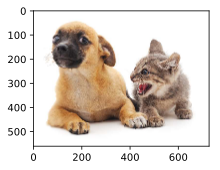

In [32]:
d2l.set_figsize()
print('imput image shape:',img.shape)
d2l.plt.imshow(img.asnumpy())

output image shape: (1122, 1456, 3)


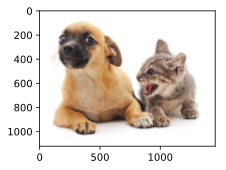

In [33]:
print('output image shape:',out_img.shape)
d2l.plt.imshow(out_img.asnumpy());

在全卷积网络中，我们将转置卷积层初始化为双线性插值的上采样。对于 1×1 卷积层，我们采用Xavier随机初始化。

In [34]:
net[-1].initialize(init=init.Constant(bilinear_kernel(num_classes,num_classes,64)))
net[-2].initialize(init=init.Xavier())


## 读取数据集
这里指定随机裁剪的输出图像的形状为 320×480 ：高和宽都可以被32整除。

In [35]:
crop_size,batch_size,colormap2label=(320,480),32,nd.zeros(256**3)
for i,cm in enumerate(d2l.VOC_COLORMAP):
    colormap2label[(cm[0]*256+cm[1])*256+cm[2]]=i
voc_dir='./data/VOCdevkit/VOC2012'

train_iter=gdata.DataLoader(d2l.VOCSegDataset(True,crop_size,voc_dir,colormap2label),batch_size,shuffle=True,
                           last_batch='discard')
test_iter=gdata.DataLoader(d2l.VOCSegDataset(False,crop_size,voc_dir,colormap2label),batch_size,last_batch='discard')

read 1114 examples
read 1078 examples


## 训练模型
现在可以开始训练模型了。这里的损失函数和准确率计算与图像分类中的并没有本质上的不同。因为我们使用转置卷积层的通道来预测像素的类别，所以在SoftmaxCrossEntropyLoss里指定了axis=1（通道维）选项。此外，模型基于每个像素的预测类别是否正确来计算准确率。

In [37]:
import mxnet as mx
ctx=mx.gpu()
loss=gloss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.1,'wd':1e-3})
d2l.train(train_iter,test_iter,net,loss,trainer,ctx,num_epochs=1)

training on cpu(0)


MXNetError: [16:08:57] c:\jenkins\workspace\mxnet\mxnet\src\storage\./cpu_device_storage.h:71: Failed to allocate CPU Memory

## 预测像素类别
在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。

In [46]:
def predict(img):
    X=test_iter._dataset.normalize_image(img)
    X=X.transpose((2,0,1)).expand_dims(axis=0)
    pred=nd.argmax(X,axis=1)
    return pred.reshape((pred.shape[1],pred.shape[2]))

为了可视化每个像素的预测类别，我们将预测类别映射回它们在数据集中的标注颜色。

In [44]:
def label2image(pred):
    colormap=nd.array(d2l.VOC_COLORMAP,dtype='uint8')
    X=pred.astype('int32')
    return colormap[X,:]

测试数据集中的图像大小和形状各异。由于模型使用了步幅为32的转置卷积层，当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向计算。这些区域的并集需要完整覆盖输入图像。当一个像素被多个区域所覆盖时，它在不同区域前向计算中转置卷积层输出的平均值可以作为softmax运算的输入，从而预测类别。

简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为 320×480 的区域：只有该区域用来预测。对于输入图像，我们先打印截取的区域，再打印预测结果，最后打印标注的类别。

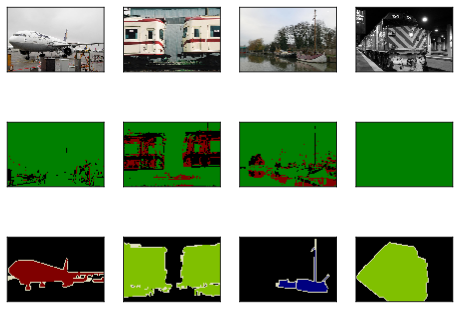

In [47]:
test_images, test_labels = d2l.read_voc_images(is_train=False,root='./data/VOCdevkit/VOC2012')
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n);

## 小结
* 可以通过矩阵乘法来实现卷积运算。
* 全卷积网络先使用卷积神经网络抽取图像特征，然后通过 1×1 卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸，从而输出每个像素的类别。
* 在全卷积网络中，可以将转置卷积层初始化为双线性插值的上采样。